# Photo Classifier: Model training

## Imports and configuration

In [1]:
from IPython.core.interactiveshell import InteractiveShell
%matplotlib inline
%load_ext autoreload
%autoreload 2
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import matplotlib.pyplot as plt
from torchsummary import summary
import logging
import random
import numpy as np
from ipywidgets import interact
import ipywidgets as widgets
from scipy.signal import savgol_filter
import torch

In [3]:
from constants import *
from utils import *
from image_transforms import *
from plotting import imshow_tensor, show_image
from data_loaders.image_loader_labels_from_folders import ImageLoaderFromFolders
from image_data import ImageData
from model import get_pretrained_model_for_transfer_learning
from file_io import save_pickle_file
from learners.utils import get_learner

In [4]:
if RANDOM_SEED:
    set_random_seeds(RANDOM_SEED)
logging.basicConfig(level=logging.INFO)

## Data loading and grouping to training, validation and test set

In [5]:
data_loader = ImageLoaderFromFolders()
data = data_loader.load_images_with_labels(SOURCE_DATA_PATH)

INFO:data_loaders.image_loader_labels_from_folders:Folder broken mug: 1/44 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder broken mug: 2/44 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder broken mug: 3/44 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder broken mug: 4/44 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder broken mug: 5/44 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder broken mug: 6/44 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder broken mug: 7/44 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder broken mug: 8/44 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder broken mug: 9/44 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder broken mug: 10/44 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder broken mug: 11/44 images loaded
INFO:data_loaders.i

INFO:data_loaders.image_loader_labels_from_folders:Folder mug filled: 2/47 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder mug filled: 3/47 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder mug filled: 4/47 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder mug filled: 5/47 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder mug filled: 6/47 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder mug filled: 7/47 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder mug filled: 8/47 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder mug filled: 9/47 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder mug filled: 10/47 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder mug filled: 11/47 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder mug filled: 12/47 images loaded
INFO:data_loaders.

In [6]:
image_data = ImageData(data, P_TRAINING, P_VALID, P_TEST)

In [7]:
print(f"Trainining set: {image_data.get_number_of_samples('training')} images")
print(f"Validation set: {image_data.get_number_of_samples('validation')} images")
print(f"Test set: {image_data.get_number_of_samples('test')} images")

Trainining set: 70 images
Validation set: 35 images
Test set: 35 images


## Image preprocessing

In [8]:
@interact(index=widgets.IntSlider(min=0, max=10, step=1, value=0, continuous_update=False))
def show(index=0, data_set_name=['training', 'validation', 'test']):
    label = image_data.get_label(index, data_set_name)
    image = image_data.get_image(index, data_set_name)
    show_image(image, label)

interactive(children=(IntSlider(value=0, continuous_update=False, description='index', max=10), Dropdown(descr…

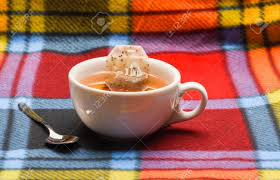

In [9]:
test_image = image_data.get_image(0, 'training')
test_image

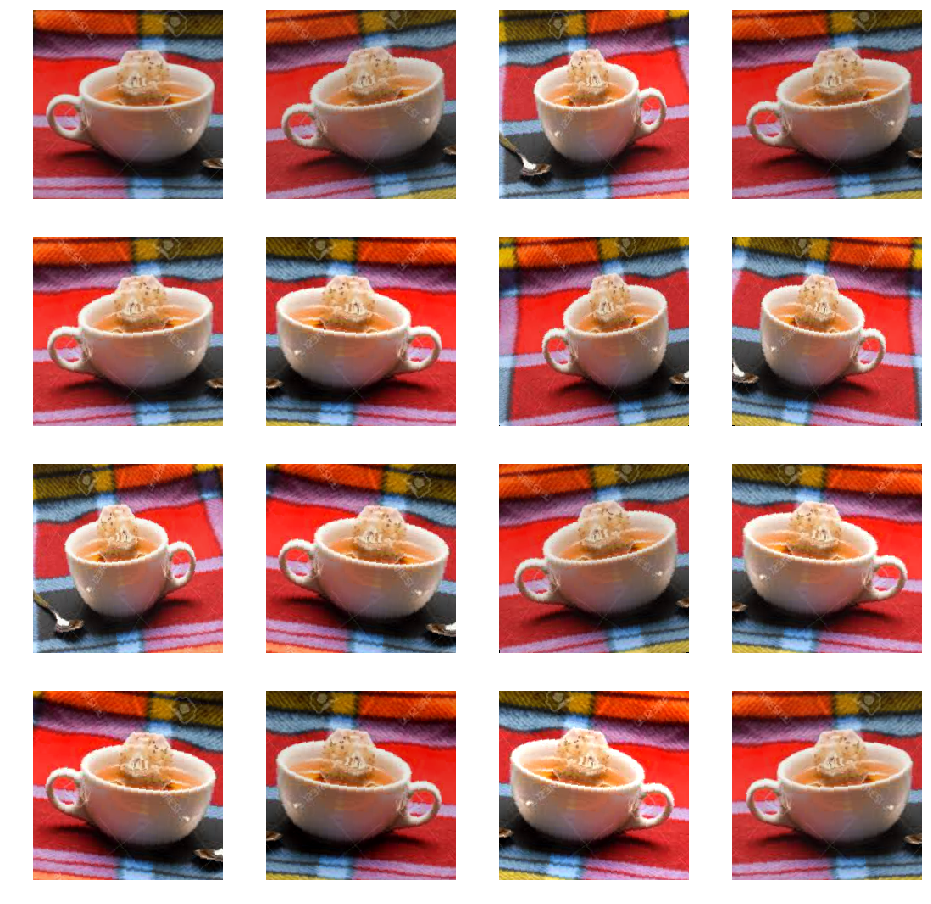

In [10]:
_ = plt.figure(figsize=(16,16))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    transformed_image = TransformsTraining(test_image)
    _ = imshow_tensor(transformed_image, ax=ax, mean=IMAGE_NET_MEAN, std=IMAGE_NET_STD)

## Model

In [11]:
n_classes = len(image_data.labels)
model = get_pretrained_model_for_transfer_learning(n_classes, IS_MULTILABEL_CLASSIFICATION, DROPOUT, MODEL_ARCHITECTURE)

In [12]:
summary(model, input_size=(3, 224, 224), batch_size=BATCH_SIZE, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [6, 64, 112, 112]           9,408
       BatchNorm2d-2          [6, 64, 112, 112]             128
              ReLU-3          [6, 64, 112, 112]               0
         MaxPool2d-4            [6, 64, 56, 56]               0
            Conv2d-5            [6, 64, 56, 56]          36,864
       BatchNorm2d-6            [6, 64, 56, 56]             128
              ReLU-7            [6, 64, 56, 56]               0
            Conv2d-8            [6, 64, 56, 56]          36,864
       BatchNorm2d-9            [6, 64, 56, 56]             128
             ReLU-10            [6, 64, 56, 56]               0
       BasicBlock-11            [6, 64, 56, 56]               0
           Conv2d-12            [6, 64, 56, 56]          36,864
      BatchNorm2d-13            [6, 64, 56, 56]             128
             ReLU-14            [6, 64,

            ReLU-125                   [6, 256]               0
         Dropout-126                   [6, 256]               0
          Linear-127                     [6, 3]             771
      LogSoftmax-128                     [6, 3]               0
Total params: 21,416,771
Trainable params: 132,099
Non-trainable params: 21,284,672
----------------------------------------------------------------
Input size (MB): 3.45
Forward/backward pass size (MB): 577.72
Params size (MB): 81.70
Estimated Total Size (MB): 662.87
----------------------------------------------------------------


## Model training

In [13]:
Learner = get_learner(IS_MULTILABEL_CLASSIFICATION)
learner = Learner(model, use_gpu=USE_GPU)
losses, losses_valid = learner.fit_model(image_data,
                                        image_transforms_training=TransformsTraining,
                                        image_transforms_validation=TransformsTest,
                                        batch_size=BATCH_SIZE,
                                        epochs=EPOCHS,
                                        learning_rate=LEARNING_RATE,
                                        weight_decay=WEIGHT_DECAY,
                                        early_stop_option=USE_EARLY_STOP)

INFO:learners.base_learner:
            Epoch: 1/40
            Validation loss: 0.8658633828163147
INFO:learners.base_learner:
            Epoch: 2/40
            Validation loss: 0.7855353355407715
INFO:learners.base_learner:
            Epoch: 3/40
            Validation loss: 0.6374953389167786
INFO:learners.base_learner:
            Epoch: 4/40
            Validation loss: 0.5701121687889099
INFO:learners.base_learner:
            Epoch: 5/40
            Validation loss: 0.5473073124885559
INFO:learners.base_learner:
            Epoch: 6/40
            Validation loss: 0.45209649205207825
INFO:learners.base_learner:
            Epoch: 7/40
            Validation loss: 0.442221075296402
INFO:learners.base_learner:
            Epoch: 8/40
            Validation loss: 0.43707147240638733
INFO:learners.base_learner:
            Epoch: 9/40
            Validation loss: 0.5132747888565063
INFO:learners.base_learner:
            Epoch: 10/40
            Validation loss: 0.413042396306991

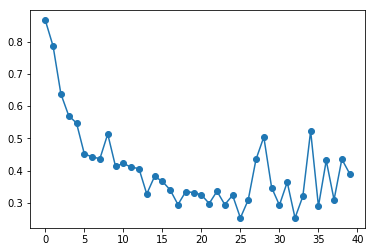

In [14]:
_ = plt.plot(losses_valid, '-o')

In [15]:
window_size = round_up_to_odd(len(losses)/4)
smoothed_losses = savgol_filter(losses, window_size, 2)

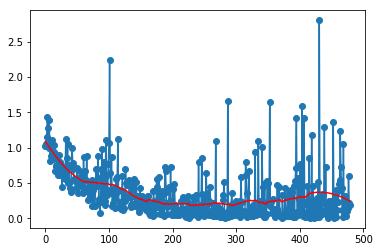

In [16]:
_ = plt.plot(losses, '-o')
_ = plt.plot(smoothed_losses, 'r-')

## Save data and model

In [17]:
save_pickle_file(learner, MODEL_FILE_PATH)
save_pickle_file(image_data, IMAGE_DATA_PATH)